In [54]:
import atd2022
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import my_mod as util
import importlib
importlib.reload(util)

<module 'my_mod' from 'c:\\Users\\Work Space\\Desktop\\LISP-ATD-2022\\my_mod.py'>

In [55]:
pd.options.display.max_columns = None

# 1-dim CNN experiment on 20-dim time series vector

# Data Import/Preprocessing

In [56]:
data = atd2022.io.read_csv()

In [57]:
test_region=data["AA"]

In [58]:
len(test_region)

215

In [59]:
test_region.tail(6)

Event,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
2018-01-01/2018-01-07,7,5,26,22,5,0,0,1,1,0,3,1,0,0,0,0,1,0,0,0
2018-01-08/2018-01-14,13,9,20,85,4,2,0,2,8,0,0,0,0,0,0,1,8,0,0,0
2018-01-15/2018-01-21,14,5,8,10,1,0,0,1,0,1,0,1,0,0,0,0,3,0,2,0
2018-01-22/2018-01-28,5,2,0,23,3,2,5,1,0,0,2,0,0,0,0,3,4,0,4,0
2018-01-29/2018-02-04,3,2,7,37,6,10,4,7,0,1,1,1,0,0,0,0,0,0,0,0
2018-02-05/2018-02-11,7,6,7,49,6,0,1,2,2,2,6,0,1,0,0,0,2,0,4,0


In [60]:
test=util.getMultiDXY(test_region, n_lags=2)

In [61]:
test

(array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 2.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 2.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  3., ...,  0.,  1.,  0.]],
 
        [[ 0.,  1.,  3., ...,  0.,  1.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.]],
 
        ...,
 
        [[13.,  9., 20., ...,  0.,  0.,  0.],
         [14.,  5.,  8., ...,  0.,  2.,  0.]],
 
        [[14.,  5.,  8., ...,  0.,  2.,  0.],
         [ 5.,  2.,  0., ...,  0.,  4.,  0.]],
 
        [[ 5.,  2.,  0., ...,  0.,  4.,  0.],
         [ 3.,  2.,  7., ...,  0.,  0.,  0.]]]),
 array([[ 0.,  1.,  3., ...,  0.,  1.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 6.,  1., 59., ...,  0.,  0.,  0.],
        ...,
        [ 5.,  2.,  0., ...,  0.,  4.,  0.],
        [ 3.,  2.,  7., ...,  0.,  0.,  0.],
        [ 7.,  6.,  7., ...,  0.,  4.,  0.]]))

In [62]:
x,y = util.getMultiDXY(test_region, n_lags=2)

In [63]:
x

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 2.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 2.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  3., ...,  0.,  1.,  0.]],

       [[ 0.,  1.,  3., ...,  0.,  1.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[13.,  9., 20., ...,  0.,  0.,  0.],
        [14.,  5.,  8., ...,  0.,  2.,  0.]],

       [[14.,  5.,  8., ...,  0.,  2.,  0.],
        [ 5.,  2.,  0., ...,  0.,  4.,  0.]],

       [[ 5.,  2.,  0., ...,  0.,  4.,  0.],
        [ 3.,  2.,  7., ...,  0.,  0.,  0.]]])

In [64]:
y

array([[ 0.,  1.,  3., ...,  0.,  1.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 6.,  1., 59., ...,  0.,  0.,  0.],
       ...,
       [ 5.,  2.,  0., ...,  0.,  4.,  0.],
       [ 3.,  2.,  7., ...,  0.,  0.,  0.],
       [ 7.,  6.,  7., ...,  0.,  4.,  0.]])

In [65]:
y.shape

(213, 20)

In [66]:
x.shape

(213, 2, 20)

In [67]:
# (#of samples, timesteps, #features(i.e. number of parallel time series))

In [68]:
n_features = 20
x_train=x.reshape((x.shape[0], x.shape[1], n_features))

In [69]:
x_train.shape

(213, 2, 20)

In [70]:
y_train=y

# CNN Model Building

In [71]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import gc
device=torch.device("cpu")

In [72]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(2,128,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(128,64)
        self.fc2 = nn.Linear(64,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        #print(x.shape)
        x = x.view(-1,128)
        #print(x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [73]:
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [74]:
class myDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [75]:
train = myDataset(x_train,y_train)
train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)

In [76]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs=inputs.to(torch.float32)
        labels=labels.to(torch.float32)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad(set_to_none = True)
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')

def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [77]:
epochs = 300
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    #Valid()
    gc.collect()

epochs 1/300


c:\Users\Work Space\anaconda3\envs\atd2022\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train_loss 104.6321029663086
epochs 2/300
train_loss 102.05918884277344
epochs 3/300
train_loss 99.90039825439453
epochs 4/300
train_loss 98.18389892578125
epochs 5/300
train_loss 96.8534164428711
epochs 6/300
train_loss 95.83843231201172
epochs 7/300
train_loss 95.0724868774414
epochs 8/300
train_loss 94.49781799316406
epochs 9/300
train_loss 94.06727600097656
epochs 10/300
train_loss 93.73944854736328
epochs 11/300
train_loss 93.4831314086914
epochs 12/300
train_loss 93.27833557128906
epochs 13/300
train_loss 93.11052703857422
epochs 14/300
train_loss 92.96934509277344
epochs 15/300
train_loss 92.8464584350586
epochs 16/300
train_loss 92.73751831054688
epochs 17/300
train_loss 92.63858795166016
epochs 18/300
train_loss 92.54749298095703
epochs 19/300
train_loss 92.46233367919922
epochs 20/300
train_loss 92.38212585449219
epochs 21/300
train_loss 92.30604553222656
epochs 22/300
train_loss 92.23377227783203
epochs 23/300
train_loss 92.16465759277344
epochs 24/300
train_loss 92.09815216

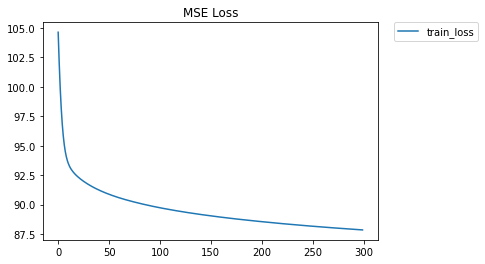

In [78]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
#plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Testing Set Preparation/Model testing

In [27]:
x_test, y_test=util.get_testXY(test_region, 4, 2)

In [28]:
x_test.shape

(4, 2, 20)

In [29]:
x_test

array([[[ 7.,  5., 26., 22.,  5.,  0.,  0.,  1.,  1.,  0.,  3.,  1.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [13.,  9., 20., 85.,  4.,  2.,  0.,  2.,  8.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  8.,  0.,  0.,  0.]],

       [[13.,  9., 20., 85.,  4.,  2.,  0.,  2.,  8.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  8.,  0.,  0.,  0.],
        [14.,  5.,  8., 10.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
          0.,  0.,  0.,  0.,  3.,  0.,  2.,  0.]],

       [[14.,  5.,  8., 10.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
          0.,  0.,  0.,  0.,  3.,  0.,  2.,  0.],
        [ 5.,  2.,  0., 23.,  3.,  2.,  5.,  1.,  0.,  0.,  2.,  0.,
          0.,  0.,  0.,  3.,  4.,  0.,  4.,  0.]],

       [[ 5.,  2.,  0., 23.,  3.,  2.,  5.,  1.,  0.,  0.,  2.,  0.,
          0.,  0.,  0.,  3.,  4.,  0.,  4.,  0.],
        [ 3.,  2.,  7., 37.,  6., 10.,  4.,  7.,  0.,  1.,  1.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]])

In [46]:
predictions = util.pred_next_n(x_test, model, 4)

In [47]:
predictions

[array([[3.8221736 , 3.5754905 , 6.365343  , 5.0804615 , 2.2210958 ,
         5.774189  , 2.2708962 , 6.9134197 , 0.21755798, 1.7439876 ,
         4.668412  , 3.045409  , 5.0322385 , 3.4332721 , 4.0676546 ,
         5.1903124 , 5.013809  , 1.281367  , 5.1814127 , 2.210539  ]],
       dtype=float32),
 array([[4.467572 , 4.7161703, 4.934844 , 5.312736 , 5.180406 , 6.0120163,
         1.3860623, 5.409691 , 1.6178313, 2.2763073, 4.4082007, 5.3159056,
         2.7845945, 1.6699076, 3.7906535, 3.9767973, 4.713743 , 0.5152869,
         3.4847867, 4.2982035]], dtype=float32),
 array([[2.6062007 , 2.39743   , 4.067546  , 2.704402  , 2.0773647 ,
         3.5302684 , 1.8716092 , 4.732978  , 0.18387724, 1.4462882 ,
         3.108828  , 3.4325364 , 2.3266537 , 2.7726576 , 2.3860552 ,
         3.0124972 , 3.3530004 , 1.1937504 , 2.7752087 , 2.3959374 ]],
       dtype=float32),
 array([[1.591152  , 1.3811927 , 3.0222938 , 1.964318  , 2.1338868 ,
         2.5744007 , 0.72510475, 3.8471332 , 0.17202048

In [48]:
predictions=np.round(predictions)

In [49]:
util.metrics_mse(predictions, y_test)

16.5
24.85
64.1
118.0


In [33]:
test=test_region.tail(2)

In [34]:
test

Event,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
2018-01-29/2018-02-04,3,2,7,37,6,10,4,7,0,1,1,1,0,0,0,0,0,0,0,0
2018-02-05/2018-02-11,7,6,7,49,6,0,1,2,2,2,6,0,1,0,0,0,2,0,4,0


In [35]:
pred = util.prod_pred_next_n(test, model)

[2.857813  2.6023679 3.3191288 4.0154867 2.0808551 4.31085   1.3738403
 4.600293  0.4252742 1.2552319 3.354269  3.7972906 2.970045  2.6541016
 3.0006    3.4840786 3.9761188 0.8936716 3.642802  1.8064644]
[2.585065   2.863817   3.1488144  3.3498971  3.2488267  3.752198
 0.8999718  3.727488   0.8815624  1.4122612  2.806958   3.7823014
 1.9080087  1.4109287  2.6896684  2.5519462  3.089497   0.28295147
 2.2468631  2.792884  ]
[1.3757962  1.0752409  2.6140752  1.6234894  1.6226709  2.2021055
 0.58838063 3.2038066  0.0737582  0.8898127  1.5328641  2.4709566
 1.185725   1.4820808  2.1238801  1.4508841  2.0982394  0.40977457
 1.930397   1.5435828 ]
[1.0689375  0.99802285 2.0385873  1.2642792  1.5648235  1.6890988
 0.46241552 2.580638   0.07667775 0.661542   1.1525006  2.0434065
 0.9084463  1.1462655  1.9371054  1.0683682  1.440491   0.5153052
 1.5265565  1.5254648 ]


In [36]:
np.round(pred)

array([[3., 3., 3., 4., 2., 4., 1., 5., 0., 1., 3., 4., 3., 3., 3., 3.,
        4., 1., 4., 2.],
       [3., 3., 3., 3., 3., 4., 1., 4., 1., 1., 3., 4., 2., 1., 3., 3.,
        3., 0., 2., 3.],
       [1., 1., 3., 2., 2., 2., 1., 3., 0., 1., 2., 2., 1., 1., 2., 1.,
        2., 0., 2., 2.],
       [1., 1., 2., 1., 2., 2., 0., 3., 0., 1., 1., 2., 1., 1., 2., 1.,
        1., 1., 2., 2.]], dtype=float32)